# Speech-to-text with RNN



![alt text](https://miro.medium.com/max/556/1*NhOH4X9wKWfO6o8faYFf-w.png)

Source: UCA 2019 Deep Learning School lab by Frederic PRECIOSO, Baptiste POUTHIER and Federico UNGOLO.

# Introduction

In this example, we are going to use RNN to do some Speech Recognition. 

Nowadays, speech recognition is a common task present in smart home assistants (Amazon Echo, Google Home), phones, TVs... Most of the time, it is done using deep learning.

## What you will learn

- The different kinds of RNN (RNN, LSTM, GRU...)

- How to load and process audio data in PyTorch

- How to implement an RNN in PyTorch

- How to create a confusion matrix


## RNN

Recurrent Neural Networks are a kind of Neural Network used to process **sequences** of data.
These sequences can be of varying length and usually have some context information.

For example, sentences (text), audio, videos have some temporal logic. In a sentence, one word depends on the word that comes before it. In a video, one frame probably looks a lot like the previous frames.

RNNs have some kind of **persistence** of information during the processing of a sequence. Thus, RNNs are used for lots of things: sentiment analysis, text completion, speech recognition, etc.

![alt text](https://www.researchgate.net/profile/Weijiang_Feng/publication/318332317/figure/fig1/AS:614309562437664@1523474221928/The-standard-RNN-and-unfolded-RNN.png)

## LSTM (Long Short-Term Memory) and GRU (Gated Recurrent Unit)

**RNN Short-term memory problem:**

*   Recurrent Neural Networks suffer from short-term memory. If a sequence is long enough, they’ll have a hard time carrying information from earlier time steps to later ones. So if you are trying to process a paragraph of text to do predictions, RNN’s may leave out important information from the beginning.

*  During back propagation, recurrent neural networks suffer from the vanishing gradient problem. Gradients are values used to update a neural networks weights. The vanishing gradient problem is when the gradient shrinks as it back propagates through time. If a gradient value becomes extremely small, it doesn’t contribute too much to the learning.

**As solution to short-term memory, LSTM and GRU were created:**

*   LSTM was introduced by this [article](https://www.bioinf.jku.at/publications/older/2604.pdf).
*   GRU was introduced by this [article](https://arxiv.org/pdf/1412.3555.pdf).

Both are **Reccurent Neural Network (RNN)** architectures which were created as the solution to short-term memory. They have internal mechanisms called gates that can regulate the flow of information. 

![alt text](https://www.mdpi.com/energies/energies-13-00147/article_deploy/html/images/energies-13-00147-g008.png)









These gates can learn which data in a sequence is important to keep or throw away. By doing that, it can pass relevant information down the long chain of sequences to make predictions.

**LSTM**

The LSTMs does have the ability to remove or add information to the cell state, carefully regulated by structures called gates.

*   the **cell state** make easy for the information to pass through the cell by combining the cells decisions
*   the **forget gate** decides what information should be thrown away from the cell state
*   the **input gate** decides which values we'll update using sigmoid ; it's combined with a tanh layer to create an update to the state
*   the **output gate**, based on the celle state, output a filtered information

**GRU**

The GRU is a modified version of the LSTM. It combines the forget and input gates into a single “update gate.” It also merges the cell state and hidden state, and makes some other changes. The resulting model is simpler than standard LSTM models, and has been growing increasingly popular.



## Libraries

Since we are working with PyTorch and sounds, we are going to use *torchaudio* instead of *torchvision*, this time.

Make sure you are using a GPU Runtime! (Runtime -> Change Runtime type)

In [2]:
!pip install torchaudio

     |████████████████████████████████| 7.6MB 9.9MB/s 


In [3]:
from IPython.display import Audio

## PyTorch things
import torch
import torchaudio
import torch.nn.functional as F

## Other libs
import matplotlib.pyplot as plt
import glob
import os
import random
from tqdm import tqdm_notebook
import torchsummary
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
import pandas as pd
import seaborn as sn

/usr/local/lib/python3.6/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


# Part 1: Working with audio data

The dataset we are using is Google's Speech Dataset (https://ai.googleblog.com/2017/08/launching-speech-commands-dataset.html).

It is composed of **"65,000 one-second long utterances of 30 short words, by thousands of different people"**.

Let's download the dataset:

In [4]:
!rm -rf ./*
!wget -O speech_commands_v0.01.tar.gz http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
!tar xzf speech_commands_v0.01.tar.gz 
!ls

--2020-12-01 07:59:29--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.15.112, 2607:f8b0:4004:807::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.15.112|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G   152MB/s    in 9.4s    

2020-12-01 07:59:39 (151 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]

_background_noise_  go	     on				   testing_list.txt
bed		    happy    one			   three
bird		    house    README.md			   tree
cat		    left     right			   two
dog		    LICENSE  seven			   up
down		    marvin   sheila			   validation_list.txt
eight		    nine     six			   wow
five		    no	     speech_commands_v0.01.tar.gz  yes
four		    off      stop			   zero


Let's print the different classes (words) that are part of this dataset.

We can see there are 30 different words.

In [5]:
classes = os.listdir()
classes.remove("LICENSE")
classes.remove("README.md")
classes.remove("_background_noise_")
classes.remove("speech_commands_v0.01.tar.gz")
classes.remove("testing_list.txt")
classes.remove("validation_list.txt")
classes.remove(".config")
print(classes)
print("Number of classes", len(classes))

['right', 'left', 'go', 'on', 'one', 'zero', 'marvin', 'five', 'happy', 'bed', 'two', 'nine', 'yes', 'six', 'eight', 'sheila', 'wow', 'up', 'down', 'seven', 'dog', 'stop', 'tree', 'cat', 'four', 'house', 'three', 'no', 'bird', 'off']
Number of classes 30


## Q1: Listen to some samples

Using the **Audio(filename)** function from IPython notebook, you can listen to an audio file directly in Colab.

Try it on some samples!

In [6]:
Audio("bed/1528225c_nohash_2.wav")

In [7]:
Audio("cat/004ae714_nohash_0.wav")

In [8]:
Audio("/content/nine/012c8314_nohash_1.wav")


## Q2: Displaying a waveform

Use **torchaudio.load** to load an audio file. Then, use matplotlib to display it.

HINT: you may have to transpose the waveform with **.t()** in order to display it

(1, 16000)

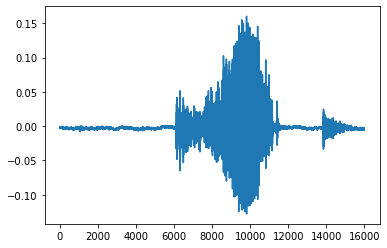

In [9]:
waveform, sample_rate = torchaudio.load("cat/004ae714_nohash_0.wav", normalization=True)

plt.plot(waveform.t())

waveform.detach().numpy().shape

## Computing MFCC features

Extracting MFCC (**Mel Frequency Cepstral Coefficients**) features is a well known signal processing technique, especially used in **ASR** (Automatic Speech Recognition). These features are meant to represent the way humans perceive sound. https://en.wikipedia.org/wiki/Mel-frequency_cepstrum

*Torchaudio* has transforms (just like the ones in *torchvision*) that allow you to compute these features:

/usr/local/lib/python3.6/dist-packages/torchaudio/functional.py:318: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "
/usr/local/lib/python3.6/dist-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/usr/local/lib/python3.6/dist-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally a

torch.Size([1, 12, 81])


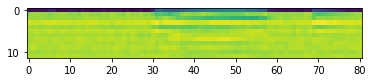

In [10]:
mfcc = torchaudio.transforms.MFCC(n_mfcc=12, log_mels=True)(waveform)
plt.figure()
plt.imshow(mfcc[0].detach().numpy())
print(mfcc.shape)

Here, we are only keeping 12 MFCC features because it is enough for our purposes.

As you can see, we are getting a Tensor of shape [1, 12, 81], because we have one audio channel (mono) with 12 coefficients over 81 time windows.

## Creating a custom audio Dataset

You may have noticed that in this dataset, the test and validation datasets are given in testing_list.txt and validation_list.txt files. 

With that, we can infer a training list as well:

In [11]:
## Read the test list
with open("testing_list.txt") as testing_f:
  testing_list = [x.strip() for x in testing_f.readlines()]

## Read the val list
with open("validation_list.txt") as val_f:
  validation_list = [x.strip() for x in val_f.readlines()]  

print("Number of testing samples", len(testing_list))
print("Number of validation samples", len(validation_list))

## Construct a train list
training_list = []
for c in classes:
  training_list += glob.glob(c + "/*")

training_list = list(filter(lambda x : not x in testing_list and not x in validation_list, training_list))
print("Number of training samples", len(training_list))

Number of testing samples 6835
Number of validation samples 6798
Number of training samples 51088


Now, we can create a custom SpeechDataset class that takes a file list in input.

In [25]:
class SpeechDataset(torch.utils.data.Dataset):
  
  def __init__(self, classes, file_list):
    
    self.classes = classes
    
    # create a map from class name to integer
    self.class_to_int = dict(zip(classes, range(len(classes))))
    
    # store the file names
    self.samples = file_list
    
    # store our MFCC transform
    self.mfcc_transform = torchaudio.transforms.MFCC(n_mfcc=12, log_mels=True)
    
  def __len__(self):
    return len(self.samples)
    
  def __getitem__(self,i):
    with torch.no_grad():
      # load a normalized waveform
      waveform,_ = torchaudio.load(self.samples[i], normalization=True)
      
      # if the waveform is too short (less than 1 second) we pad it with zeroes
      if waveform.shape[1] < 16000:
        waveform = F.pad(input=waveform, pad=(0, 16000 - waveform.shape[1]), mode='constant', value=0)
      
      # then, we apply the transform
      mfcc = self.mfcc_transform(waveform).squeeze(0).transpose(0,1)
    
    # get the label from the file name
    label = self.samples[i].split("/")[0]
    
    # return the mfcc coefficient with the sample label
    return mfcc, self.class_to_int[label]

## Q3: Create instances of the SpeechDataset for the train and val sets

Fill the code below to create your Dataset objects for training.

In [13]:
train_set = SpeechDataset(classes, training_list)
val_set =SpeechDataset(classes, validation_list)

print(train_set[5][0].shape)

torch.Size([81, 12])


/usr/local/lib/python3.6/dist-packages/torchaudio/functional.py:318: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


(<matplotlib.image.AxesImage at 0x7f2e6fafb898>, 0)

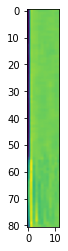

In [14]:
plt.imshow(train_set[2][0].detach().numpy()), train_set[2][1]

(<matplotlib.image.AxesImage at 0x7f2e6facb358>, 0)

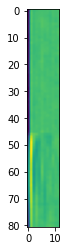

In [15]:
plt.imshow(train_set[5][0].detach().numpy()),train_set[5][1]

## Q4: Create Dataloaders for training and validation

Fill the code below to create DataLoaders with the Datasets you just created.

Do not forget to add shuffling to the training DataLoader.

Print a batch of data to make sure everything works.

In [16]:
train_dl = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_set, batch_size=16)

print(next(iter(train_dl)))

[tensor([[[-1.5385e+02,  1.6302e+00,  1.0906e-01,  ...,  1.8200e+00,
           2.5846e-01, -1.2024e+00],
         [-1.5173e+02,  3.5011e+00,  1.6630e-01,  ...,  3.6819e+00,
           5.3177e-01, -2.7552e+00],
         [-1.5428e+02,  1.2418e+00,  1.0846e-01,  ...,  1.6836e+00,
           4.3054e-01, -8.1284e-01],
         ...,
         [-1.5387e+02,  2.0429e+00,  2.2207e+00,  ...,  1.0203e+00,
           8.6475e-01,  1.0403e+00],
         [-1.5440e+02,  1.3053e+00,  1.5306e+00,  ...,  9.9263e-01,
           6.8016e-01,  7.9589e-01],
         [-1.5449e+02,  1.2623e+00,  1.4845e+00,  ...,  7.1171e-01,
           8.9580e-01,  9.2716e-01]],

        [[-6.6343e+01,  1.6933e+01, -1.8647e+00,  ...,  1.2811e+00,
          -2.9737e-01,  2.4001e+00],
         [-6.6141e+01,  1.8418e+01, -1.7433e+00,  ..., -1.7704e+00,
          -2.6069e+00,  3.6114e-01],
         [-6.7581e+01,  1.9550e+01, -2.8370e+00,  ..., -7.4007e-01,
          -5.5563e+00, -6.9935e-01],
         ...,
         [-6.8156e+01,  

# Part 2: Implementing a simple Recurrent Neural Network

For our network, we are going to use an **RNN module** from torch.nn (which can have multiple layers, or cells).

This module has an **input size**, which in our case will be equal to **the number of MFCC features (12)**. The input size is the number of dimensions of **x** in the image below.

It also has an **hidden size**, which is the size of the output of the layers as well as the size of the internal representation of the features. We are going to choose **256** to start, but feel free to change that. This is the dimension of **h** in the image below.

PyTorch RNN modules have a **number of layers**, which is simply the number of stacked **RNN Cells**. We are going to use 2 cells here, but feel free to change that as well. This is the **depth** in the image below.

Then, in order to get as many output as the number of classes in our dataset, we need to have a **Linear layer** that goes from **256 inputs (the hidden size) to 30 outputs (the number of classes).**

Finally, to output categorical probabilities, we use a **Softmax layer.**

![alt text](https://i.stack.imgur.com/SjnTl.png)

## Q4: Implement the network

Fill the code below to implement the network.

In [28]:
class SpeechRNN(torch.nn.Module):
  
  def __init__(self):
    super(SpeechRNN, self).__init__()
    
    self.rnn = torch.nn.LSTM(input_size = 12, 
                              hidden_size= 256, 
                              num_layers = 4, 
                              batch_first=True)
    
    self.out_layer = torch.nn.Linear(256, 30)
    
    self.softmax = torch.nn.LogSoftmax(dim=1)
    
  def forward(self, x):
    
    out, _ = self.rnn(x)
    
    x = self.out_layer(out[:,-1,:])
    
    return self.softmax(x)

# To add more layers

In [29]:
class SpeechRNN(torch.nn.Module):
  
  def __init__(self):
    super(SpeechRNN, self).__init__()
    
    self.rnn = torch.nn.LSTM(input_size = 12, 
                              hidden_size= 256, 
                              num_layers = 4, 
                              batch_first=True)
    
    self.h1 = torch.nn.Linear(256, 256)

    self.h2 = torch.nn.Linear(256, 256)

    self.out_layer = torch.nn.Linear(256, 30)
    
    self.softmax = torch.nn.LogSoftmax(dim=1)
    
  def forward(self, x):
    
    x, _ = self.rnn(x)

    x = self.h1(x)

    out = self.h2(x)
    
    x = self.out_layer(out[:,-1,:])
    
    return self.softmax(x)

Use this code to check that your implementation is working.

In [30]:
net = SpeechRNN().cuda()
batch = next(iter(train_dl))[0]
print(batch.shape)
y = net(batch.cuda())
print(y.shape)
print(net)

torch.Size([16, 81, 12])
SpeechRNN(
  (rnn): LSTM(12, 256, num_layers=4, batch_first=True)
  (h1): Linear(in_features=256, out_features=256, bias=True)
  (h2): Linear(in_features=256, out_features=256, bias=True)
  (out_layer): Linear(in_features=256, out_features=30, bias=True)
  (softmax): LogSoftmax(dim=1)
)
torch.Size([16, 30])
SpeechRNN(
  (rnn): LSTM(12, 256, num_layers=4, batch_first=True)
  (h1): Linear(in_features=256, out_features=256, bias=True)
  (h2): Linear(in_features=256, out_features=256, bias=True)
  (out_layer): Linear(in_features=256, out_features=30, bias=True)
  (softmax): LogSoftmax(dim=1)
)


# Part 3: Training the network

As usual, we need to define a loss and an optimizer. Since we have a categorical classification problem, we use cross-entropy (negative log likelihood).

We can use the Adam optimizer, feel free to change it or the learning rate.

In [20]:
##RE-RUN THIS CODE TO GET A "NEW" NETWORK

LEARNING_RATE = 0.001

## Create an instance of our network
net = SpeechRNN()

## Move it to the GPU
net = net.cuda()

# Negative log likelihood loss
criterion = torch.nn.NLLLoss()

# Adam optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

## Q5: Training loop

We also need to write a training loop. Fill the code below to create it:

In [21]:
## NUMBER OF EPOCHS TO TRAIN
N_EPOCHS = 5

epoch_loss, epoch_acc, epoch_val_loss, epoch_val_acc = [], [], [], []

for e in range(N_EPOCHS):
  
  print("EPOCH:",e)
  
  ### TRAINING LOOP
  running_loss = 0
  running_accuracy = 0
  
  ## Put the network in training mode
  net.train()
  
  for i, batch in enumerate(tqdm_notebook(train_dl)):
    
    # Get a batch from the dataloader
    x = batch[0]
    labels = batch[1]
    
    # move the batch to GPU
    x = x.cuda()
    labels = labels.cuda()

    # Compute the network output
    y = net(x)
    
    # Compute the loss
    loss = criterion(y, labels)
    
    # Reset the gradients
    optimizer.zero_grad()
    
    # Compute the gradients
    loss.backward()
    
    # Apply one step of the descent algorithm to update the weights
    optimizer.step()
    
    ## Compute some statistics
    with torch.no_grad():
      running_loss += loss.item()
      running_accuracy += (y.max(1)[1] == labels).sum().item()
    
  print("Training accuracy:", running_accuracy/float(len(train_set)),
        "Training loss:", running_loss/float(len(train_set)))
  
  epoch_loss.append(running_loss/len(train_set))
  epoch_acc.append(running_accuracy/len(train_set))
  
  ### VALIDATION LOOP
  ## Put the network in validation mode
  net.eval()
  
  running_val_loss = 0
  running_val_accuracy = 0
  
  for i, batch in enumerate(val_dl):
    
    with torch.no_grad():
      # Get a batch from the dataloader
      x = batch[0]
      labels = batch[1]

      # move the batch to GPU
      x = x.cuda()
      labels = labels.cuda()

      # Compute the network output
      y= net(x)
      
      # Compute the loss
      loss = criterion(y, labels)
      
      running_val_loss += loss.item()
      running_val_accuracy += (y.max(1)[1] == labels).sum().item()
    
  print("Validation accuracy:", running_val_accuracy/float(len(val_set)),
        "Validation loss:", running_val_loss/float(len(val_set)))
  
  epoch_val_loss.append(running_val_loss/len(val_set))
  epoch_val_acc.append(running_val_accuracy/len(val_set))
      

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Training accuracy: 0.43560131537738805 Training loss: 0.10939837121129073
Validation accuracy: 0.6784348337746396 Validation loss: 0.06715835872889617
EPOCH: 1



Training accuracy: 0.7483557782649546 Training loss: 0.053323505527255
Validation accuracy: 0.7899382171226832 Validation loss: 0.04465228806728747
EPOCH: 2



Training accuracy: 0.828824772940808 Training loss: 0.037746015523669435
Validation accuracy: 0.833480435422183 Validation loss: 0.03695611460830345
EPOCH: 3



Training accuracy: 0.8613960225493267 Training loss: 0.030534813949935118
Validation accuracy: 0.8480435422182995 Validation loss: 0.03335387352300878
EPOCH: 4



Training accuracy: 0.881537738803633 Training loss: 0.026315033238976458
Validation accuracy: 0.8487790526625478 Validation loss: 0.034186665453441796


In [22]:
!nvidia-smi

Tue Dec  1 08:10:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    29W /  70W |   1077MiB / 15079MiB |     31%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Q6: From RNN to LSTM/GRU

As you can see, the accuracy is pretty bad when we are only using "regular" RNNs. These are not used very much in practice nowadays because they do not have long-term memory. This means that by the time the network is done processing the whole audio sample, it probably has already forgotten the important parts of it. **Replace the RNN module in your network (Q4) with an LSTM or a GRU module (as you want). Train a new network and watch that accuracy go up!**

# Part 4: Evaluation

Now, we need to evaluate our network on the test set.

Use the code below to do that:

In [23]:
# Create a test dataset instance
test_dataset = SpeechDataset(classes, testing_list)

# Create a DataLoader
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=64)

net.eval()

test_loss = 0
test_accuracy = 0

preds, y_test = np.array([]), np.array([])

for i, batch in enumerate(test_dl):

  with torch.no_grad():
    # Get a batch from the dataloader
    x = batch[0]
    labels = batch[1]

    # move the batch to GPU
    x = x.cuda()
    labels = labels.cuda()

    # Compute the network output
    y = net(x)

    # Compute the loss
    loss = criterion(y, labels)
    
    ## Store all the predictions an labels for later
    preds = np.hstack([preds, y.max(1)[1].cpu().numpy()])
    y_test = np.hstack([y_test, labels.cpu().numpy()])

    test_loss += loss.item()
    test_accuracy += (y.max(1)[1] == labels).sum().item()

print("Test accuracy:", test_accuracy/float(len(test_dataset)),
      "Test loss:", test_loss/float(len(test_dataset)))

/usr/local/lib/python3.6/dist-packages/torchaudio/functional.py:318: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


Test accuracy: 0.8536942209217264 Test loss: 0.008771611689082357


## Confusion matrix

In classification problems, it is common to use a confusion matrix to visualize which particular classes the model struggles with.

Use the code below to generate a confusion matrix. What is the confusion that your network makes the most?

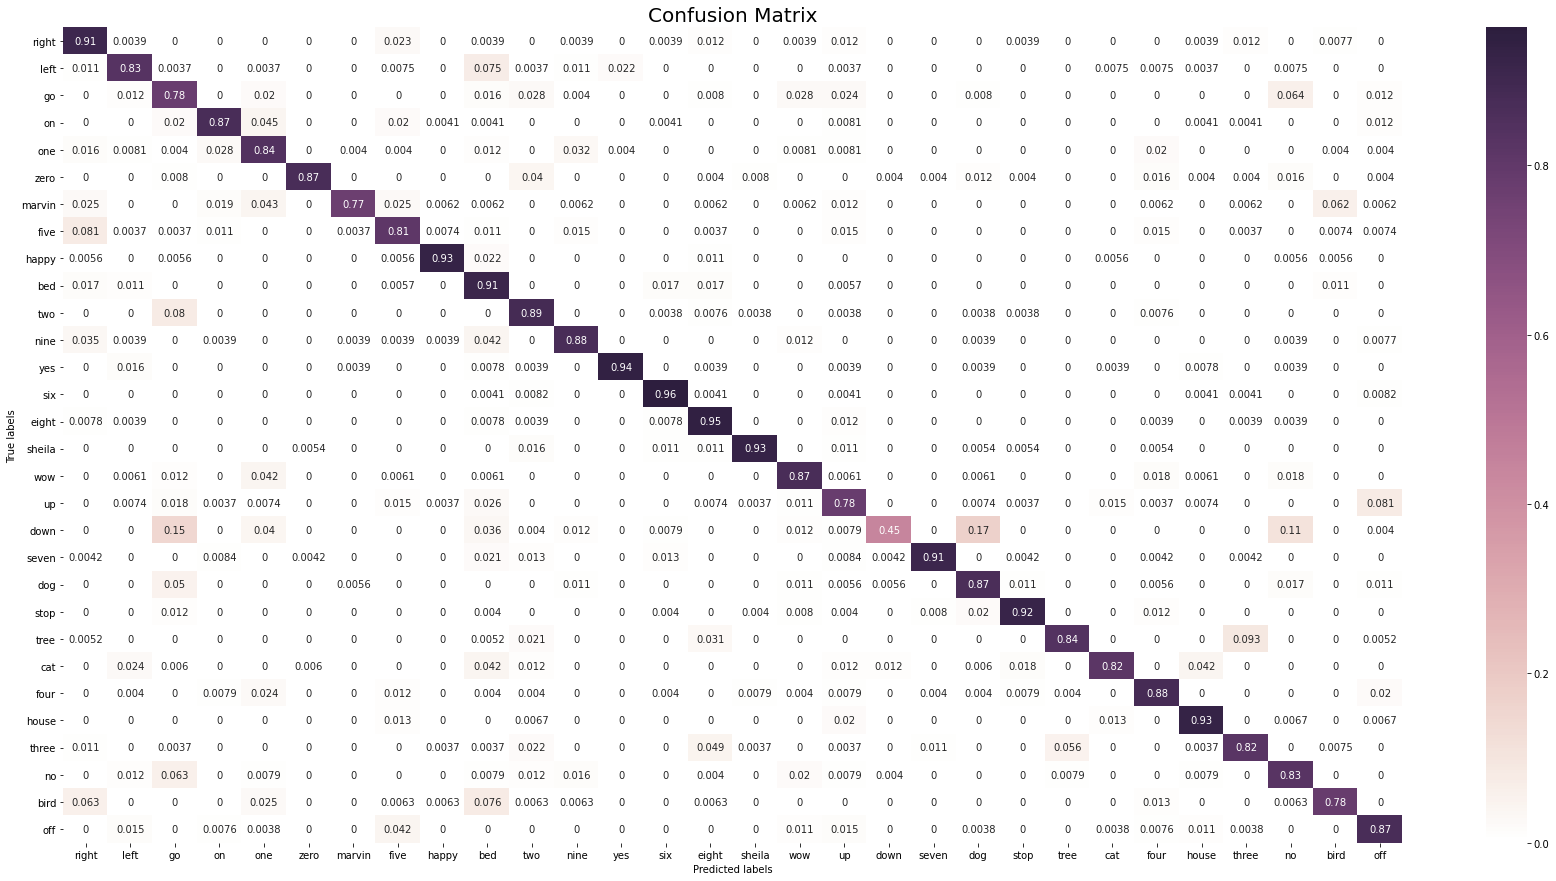

In [24]:
def show_confusion_matrix(pred, Y_TEST, classes):

  cm = confusion_matrix(y_true=Y_TEST, y_pred=pred)
  cm = normalize(cm,axis=1,norm='l1')
  
  df_cm = pd.DataFrame(cm, index = classes, columns = classes)
  
  plt.figure(figsize=(30,15))
  
  cmap = sn.cubehelix_palette(light=1, as_cmap=True)
  sn.heatmap(df_cm, annot=True,cmap=cmap)
  plt.title('Confusion Matrix',fontdict={'fontsize':20})
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.show


show_confusion_matrix(preds, y_test, classes)